In [1]:
from transformers import AutoTokenizer, AutoModel
import senteval
import torch
import torch.nn as nn
import json
import os
from tqdm import tqdm

In [2]:
from sentence_transformers.readers import InputExample
from torch.utils.data import DataLoader, Dataset
import gzip
import csv

sts_dataset_path = '../datasets/stsbenchmark.tsv.gz'

if not os.path.exists(sts_dataset_path):
    util.http_get('https://sbert.net/datasets/stsbenchmark.tsv.gz', sts_dataset_path)

texts = []
with gzip.open(sts_dataset_path, 'rt', encoding='utf8') as fIn:
    reader = csv.DictReader(fIn, delimiter='\t', quoting=csv.QUOTE_NONE)
    for row in reader:
        if row['split'] == 'test':
            texts.append(row['sentence1'])
            texts.append(row['sentence2'])

class BaseDataset(Dataset):
    def __init__(self, texts, scale=None):
        # samples in format [[sentences1], [sentences2], [scores or labels]]
        # scores range is [0, 5], labels are strings
        self.texts = []
        for t in texts:
            self.texts.append(t)

    def __getitem__(self, idx):
        return self.texts[idx]

    def __len__(self):
        return len(self.texts)

dataset = BaseDataset(texts)
loader = DataLoader(dataset, batch_size=128)

In [3]:
# taken from https://github.com/google-research/google-research/blob/master/representation_similarity/Demo.ipynb

import numpy as np

def gram_linear(x):
    """Compute Gram (kernel) matrix for a linear kernel.

    Args:
    x: A num_examples x num_features matrix of features.

    Returns:
    A num_examples x num_examples Gram matrix of examples.
    """
    return x.dot(x.T)


def gram_rbf(x, threshold=1.0):
    """Compute Gram (kernel) matrix for an RBF kernel.

    Args:
    x: A num_examples x num_features matrix of features.
    threshold: Fraction of median Euclidean distance to use as RBF kernel
        bandwidth. (This is the heuristic we use in the paper. There are other
        possible ways to set the bandwidth; we didn't try them.)

    Returns:
    A num_examples x num_examples Gram matrix of examples.
    """
    dot_products = x.dot(x.T)
    sq_norms = np.diag(dot_products)
    sq_distances = -2 * dot_products + sq_norms[:, None] + sq_norms[None, :]
    sq_median_distance = np.median(sq_distances)
    return np.exp(-sq_distances / (2 * threshold ** 2 * sq_median_distance))


def center_gram(gram, unbiased=False):
    """Center a symmetric Gram matrix.

    This is equvialent to centering the (possibly infinite-dimensional) features
    induced by the kernel before computing the Gram matrix.

    Args:
    gram: A num_examples x num_examples symmetric matrix.
    unbiased: Whether to adjust the Gram matrix in order to compute an unbiased
        estimate of HSIC. Note that this estimator may be negative.

    Returns:
    A symmetric matrix with centered columns and rows.
    """
    if not np.allclose(gram, gram.T):
        raise ValueError('Input must be a symmetric matrix.')
    gram = gram.copy()

    if unbiased:
        # This formulation of the U-statistic, from Szekely, G. J., & Rizzo, M.
        # L. (2014). Partial distance correlation with methods for dissimilarities.
        # The Annals of Statistics, 42(6), 2382-2412, seems to be more numerically
        # stable than the alternative from Song et al. (2007).
        n = gram.shape[0]
        np.fill_diagonal(gram, 0)
        means = np.sum(gram, 0, dtype=np.float64) / (n - 2)
        means -= np.sum(means) / (2 * (n - 1))
        gram -= means[:, None]
        gram -= means[None, :]
        np.fill_diagonal(gram, 0)
    else:
        means = np.mean(gram, 0, dtype=np.float64)
        means -= np.mean(means) / 2
        gram -= means[:, None]
        gram -= means[None, :]

    return gram


def cka(gram_x, gram_y, debiased=False):
    """Compute CKA.

    Args:
    gram_x: A num_examples x num_examples Gram matrix.
    gram_y: A num_examples x num_examples Gram matrix.
    debiased: Use unbiased estimator of HSIC. CKA may still be biased.

    Returns:
    The value of CKA between X and Y.
    """
    gram_x = center_gram(gram_x, unbiased=debiased)
    gram_y = center_gram(gram_y, unbiased=debiased)

    # Note: To obtain HSIC, this should be divided by (n-1)**2 (biased variant) or
    # n*(n-3) (unbiased variant), but this cancels for CKA.
    scaled_hsic = gram_x.ravel().dot(gram_y.ravel())

    normalization_x = np.linalg.norm(gram_x)
    normalization_y = np.linalg.norm(gram_y)
    return scaled_hsic / (normalization_x * normalization_y)


def _debiased_dot_product_similarity_helper(xty, sum_squared_rows_x, sum_squared_rows_y, squared_norm_x, squared_norm_y, n):
    """Helper for computing debiased dot product similarity (i.e. linear HSIC)."""
    # This formula can be derived by manipulating the unbiased estimator from
    # Song et al. (2007).
    return (xty - n / (n - 2.) * sum_squared_rows_x.dot(sum_squared_rows_y)
      + squared_norm_x * squared_norm_y / ((n - 1) * (n - 2)))


def feature_space_linear_cka(features_x, features_y, debiased=False):
    """Compute CKA with a linear kernel, in feature space.

    This is typically faster than computing the Gram matrix when there are fewer
    features than examples.

    Args:
    features_x: A num_examples x num_features matrix of features.
    features_y: A num_examples x num_features matrix of features.
    debiased: Use unbiased estimator of dot product similarity. CKA may still be
        biased. Note that this estimator may be negative.

    Returns:
    The value of CKA between X and Y.
    """
    features_x = features_x - np.mean(features_x, 0, keepdims=True)
    features_y = features_y - np.mean(features_y, 0, keepdims=True)

    dot_product_similarity = np.linalg.norm(features_x.T.dot(features_y)) ** 2
    normalization_x = np.linalg.norm(features_x.T.dot(features_x))
    normalization_y = np.linalg.norm(features_y.T.dot(features_y))

    if debiased:
        n = features_x.shape[0]
        # Equivalent to np.sum(features_x ** 2, 1) but avoids an intermediate array.
        sum_squared_rows_x = np.einsum('ij,ij->i', features_x, features_x)
        sum_squared_rows_y = np.einsum('ij,ij->i', features_y, features_y)
        squared_norm_x = np.sum(sum_squared_rows_x)
        squared_norm_y = np.sum(sum_squared_rows_y)

        dot_product_similarity = _debiased_dot_product_similarity_helper(
            dot_product_similarity, sum_squared_rows_x, sum_squared_rows_y,
            squared_norm_x, squared_norm_y, n)
        normalization_x = np.sqrt(_debiased_dot_product_similarity_helper(
            normalization_x ** 2, sum_squared_rows_x, sum_squared_rows_x,
            squared_norm_x, squared_norm_x, n))
        normalization_y = np.sqrt(_debiased_dot_product_similarity_helper(
            normalization_y ** 2, sum_squared_rows_y, sum_squared_rows_y,
            squared_norm_y, squared_norm_y, n))

    return dot_product_similarity / (normalization_x * normalization_y)

In [4]:
DEVICE = "cuda:0"

def batch_to_device(d, device):
    return {k: v.to(device) for k, v in d.items()}
    
class MeanPooling(nn.Module):
    def __init__(self, starting_state):
        super().__init__()
        self.starting_state = starting_state

    def forward(self, x, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(x.size()).float().to(DEVICE)
        emb_sum = torch.sum(x * input_mask_expanded, dim=1)
        sum_mask = torch.clamp(input_mask_expanded.sum(dim=1), min=1e-9) # denominator
        emb_mean = emb_sum / sum_mask
        return emb_mean

    
class Bert:

    def __init__(self, starting_state=12, path=None):
        self.tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
        if path is None:
            self.model = AutoModel.from_pretrained("bert-base-cased").to(DEVICE)
        else:
            self.model = torch.load(path).to(DEVICE)
        self.pooling = MeanPooling(starting_state)
        self.model.eval()
    
    @torch.no_grad()
    def forward(self, loader):
        activations = []
        for _, t in tqdm(enumerate(loader)):
            tokenized = self.tokenizer(t, padding=True, truncation=True, return_tensors="pt")

            tokenized_device = batch_to_device(tokenized, DEVICE)

            out = self.model(**tokenized_device, output_hidden_states=True).hidden_states[self.pooling.starting_state]
            out_mean = self.pooling(out, tokenized_device["attention_mask"])
            
            activations.append(out_mean)
            
        return torch.cat(activations, dim=0).detach().cpu().numpy()

class Electra:

    def __init__(self, starting_state=12, path=None):
        self.tokenizer = AutoTokenizer.from_pretrained("google/electra-base-discriminator")
        if path is None:
            self.model = AutoModel.from_pretrained("google/electra-base-discriminator").to(DEVICE)
        else:
            self.model = torch.load(path).to(DEVICE)
        self.pooling = MeanPooling(starting_state)
        self.model.eval()
    
    @torch.no_grad()
    def forward(self, loader):
        activations = []
        for _, t in tqdm(enumerate(loader)):
            tokenized = self.tokenizer(t, padding=True, truncation=True, return_tensors="pt")

            tokenized_device = batch_to_device(tokenized, DEVICE)

            out = self.model(**tokenized_device, output_hidden_states=True).hidden_states[self.pooling.starting_state]
            out_mean = self.pooling(out, tokenized["attention_mask"])
            
            activations.append(out_mean)
        
        return torch.cat(activations, dim=0).detach().cpu().numpy()
    
class ElectraGenerator:

    def __init__(self, starting_state=12, path=None):
        self.tokenizer = AutoTokenizer.from_pretrained("google/electra-base-generator")
        if path is None:
            self.model = AutoModel.from_pretrained("google/electra-base-generator").to(DEVICE)
        else:
            self.model = torch.load(path).to(DEVICE)
        self.pooling = MeanPooling(starting_state)
        self.model.eval()
    
    @torch.no_grad()
    def forward(self, loader):
        activations = []
        for _, t in tqdm(enumerate(loader)):
            tokenized = self.tokenizer(t, padding=True, truncation=True, return_tensors="pt")

            tokenized_device = batch_to_device(tokenized, DEVICE)

            out = self.model(**tokenized_device, output_hidden_states=True).hidden_states[self.pooling.starting_state]
            out_mean = self.pooling(out, tokenized["attention_mask"])
            
            activations.append(out_mean)
        
        return torch.cat(activations, dim=0).detach().cpu().numpy()

In [5]:
models_electra = [
    "model_2024_01_22_23_24",
    "model_2024_01_23_00_41",
    "model_2024_01_23_02_05",
    "model_2024_01_23_03_37",
    "model_2024_01_23_05_18",
    "model_2024_01_23_07_08",
    "model_2024_01_23_09_07",
    "model_2024_01_23_11_14",
    "model_2024_01_23_19_21",
    "model_2024_01_23_21_43",
    "model_2024_01_24_00_13",
    "model_2024_01_24_02_51",
    "model_2024_01_24_05_37"
]

activations_electra = []
for i, m in enumerate(models_electra):
    electra = Electra(starting_state=i, path=f"../output/google-electra-base-discriminator/mean/{i}_to_{i+1}/{m}.pt")
    act_i = electra.forward(loader)
    activations_electra.append(act_i)
    
print(len(activations_electra), activations_electra[0].shape)

22it [00:02,  8.53it/s]
22it [00:02,  9.54it/s]
22it [00:02,  9.29it/s]
22it [00:02,  9.38it/s]
22it [00:02,  9.58it/s]
22it [00:02,  9.69it/s]
22it [00:02,  9.09it/s]
22it [00:02,  9.47it/s]
22it [00:02,  9.46it/s]
22it [00:02,  9.45it/s]
22it [00:02,  9.45it/s]
22it [00:02,  9.42it/s]
22it [00:02,  9.42it/s]

13 (2758, 768)


In [6]:
models_bert = [
    "model_2024_01_22_23_30",
    "model_2024_01_23_00_48",
    "model_2024_01_23_02_13",
    "model_2024_01_23_03_46",
    "model_2024_01_23_05_28",
    "model_2024_01_23_07_18",
    "model_2024_01_23_09_18",
    "model_2024_01_23_11_26",
    "model_2024_01_23_19_34",
    "model_2024_01_23_21_57",
    "model_2024_01_24_00_27",
    "model_2024_01_24_03_06",
    "model_2024_01_24_05_52"
]

activations_bert = []
for i,m in enumerate(models_bert):
    bert = Bert(starting_state=i, path=f"../output/bert-base-cased/mean/{i}_to_{i+1}/{m}.pt")
    act_i = bert.forward(loader)
    activations_bert.append(act_i)
    
print(len(activations_bert), activations_bert[0].shape)

22it [00:02,  9.54it/s]
22it [00:02,  9.58it/s]
22it [00:02,  9.56it/s]
22it [00:02,  9.56it/s]
22it [00:02,  9.56it/s]
22it [00:02,  9.57it/s]
22it [00:02,  9.56it/s]
22it [00:02,  9.54it/s]
22it [00:02,  9.55it/s]
22it [00:02,  9.54it/s]
22it [00:02,  9.55it/s]
22it [00:02,  9.54it/s]
22it [00:02,  9.54it/s]

13 (2758, 768)


In [7]:
models_electra_gen = [
    "model_2024_01_22_23_19",
    "model_2024_01_23_00_35",
    "model_2024_01_23_01_59",
    "model_2024_01_23_03_31",
    "model_2024_01_23_05_12",
    "model_2024_01_23_07_01",
    "model_2024_01_23_08_59",
    "model_2024_01_23_11_06",
    "model_2024_01_23_19_13",
    "model_2024_01_23_21_35",
    "model_2024_01_24_00_04",
    "model_2024_01_24_02_42",
    "model_2024_01_24_05_27"
]

activations_electra_gen = []
for i, m in enumerate(models_electra_gen):
    electra_gen = ElectraGenerator(starting_state=i, path=f"../output/google-electra-base-generator/mean/{i}_to_{i+1}/{m}.pt")
    act_i = electra_gen.forward(loader)
    activations_electra_gen.append(act_i)
    
print(len(activations_electra_gen), activations_electra_gen[0].shape)

22it [00:00, 46.58it/s]
22it [00:00, 46.85it/s]
22it [00:00, 46.58it/s]
22it [00:00, 46.86it/s]
22it [00:00, 46.69it/s]
22it [00:00, 46.82it/s]
22it [00:00, 46.85it/s]
22it [00:00, 38.31it/s]
22it [00:00, 46.73it/s]
22it [00:00, 47.13it/s]
22it [00:00, 47.06it/s]
22it [00:00, 46.83it/s]
22it [00:00, 46.62it/s]

13 (2758, 256)


In [8]:
electra_activations_np = np.array(activations_electra)
bert_activations_np = np.array(activations_bert)
electra_activations_gen_np = np.array(activations_electra_gen)

electra_activations_gen_np.shape, electra_activations_np.shape, bert_activations_np.shape

((13, 2758, 256), (13, 2758, 768), (13, 2758, 768))

In [9]:
import matplotlib.pyplot as plt

def plot_heatmap_cka(model_acts1, model_acts2, x_label, y_label, rbf_val=0.4):
    linear_heatmap = np.random.random((len(model_acts1), len(model_acts2)))
    #rbf_heatmap = np.random.random((len(model_acts1), len(model_acts2)))
    for i, m1 in tqdm(enumerate(model_acts1)):
        for j, m2 in enumerate(model_acts2):
            linear_heatmap[i][j] = cka(gram_linear(m1), gram_linear(m2))
            #rbf_heatmap[i][j] = cka(gram_rbf(m1, rbf_val), gram_rbf(m2, rbf_val))


    plt.title("CKA using a linear kernel")
    plt.xlabel(f"Hidden layer of {x_label}")
    plt.ylabel(f"Hidden layer of {y_label}")
    tmp = plt.imshow(linear_heatmap)#, vmin=0, vmax=1)
    ax = tmp.axes
    ax.invert_yaxis()
    plt.colorbar()
    plt.show()
    
    #plt.title(f"CKA using an RBF kernel with value {rbf_val}")
    #plt.xlabel(f"Hidden layer of {x_label}")
    #plt.ylabel(f"Hidden layer of {y_label}")
    #tmp = plt.imshow(rbf_heatmap, vmin=0, vmax=1)
    #ax = tmp.axes
    #ax.invert_yaxis()
    #plt.colorbar()
    #plt.show()


13it [00:29,  2.30s/it]


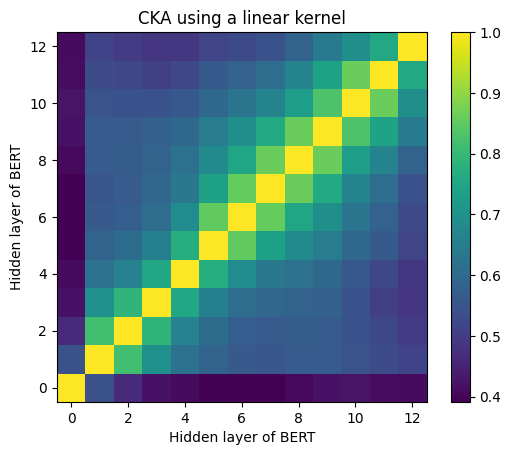

In [10]:
plot_heatmap_cka(bert_activations_np, bert_activations_np, "BERT", "BERT")

13it [00:29,  2.27s/it]


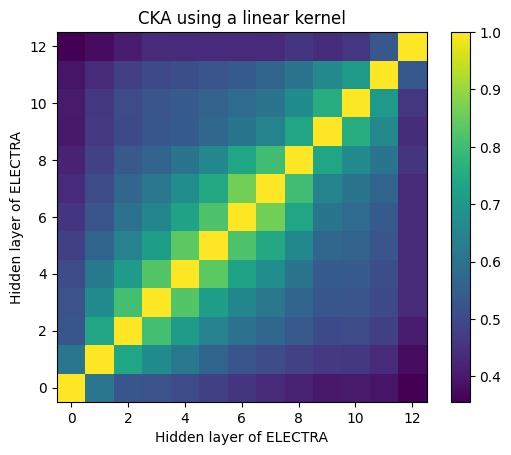

In [11]:
plot_heatmap_cka(electra_activations_np, electra_activations_np, "ELECTRA", "ELECTRA")

13it [00:27,  2.10s/it]


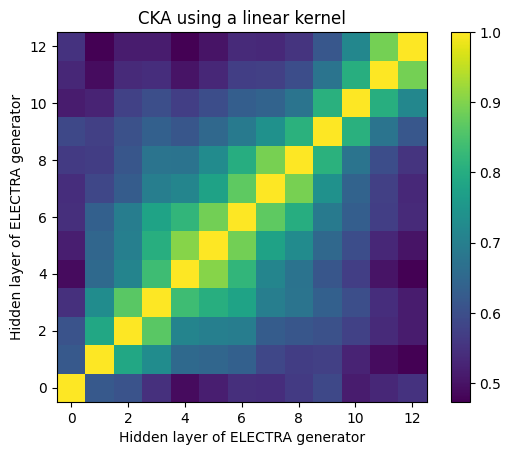

In [13]:
plot_heatmap_cka(electra_activations_gen_np, electra_activations_gen_np, "ELECTRA generator", "ELECTRA generator")

13it [00:28,  2.20s/it]


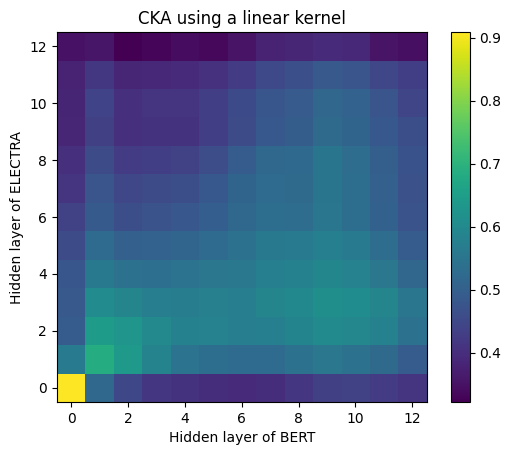

In [14]:
plot_heatmap_cka(electra_activations_np, bert_activations_np, "BERT", "ELECTRA")

13it [00:28,  2.16s/it]


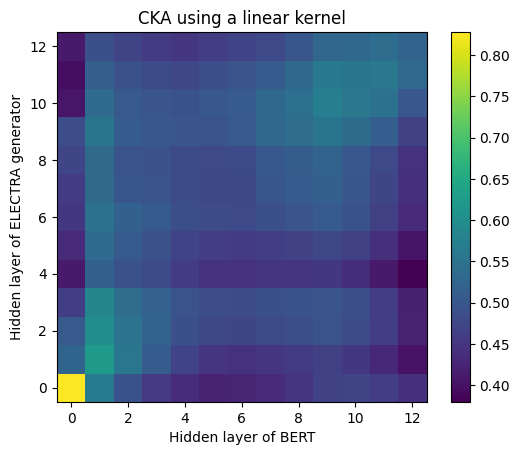

In [15]:
plot_heatmap_cka(electra_activations_gen_np, bert_activations_np, "BERT", "ELECTRA generator")

In [16]:
activations_bert = []
for i in range(13):
    bert = Bert(starting_state=i)
    act_i = bert.forward(loader)
    activations_bert.append(act_i)
    
print(len(activations_bert), activations_bert[0].shape)

22it [00:02,  9.86it/s]
22it [00:02,  9.81it/s]
22it [00:02,  9.76it/s]
22it [00:02,  9.81it/s]
22it [00:02,  9.85it/s]
22it [00:02,  9.88it/s]
22it [00:02,  9.86it/s]
22it [00:02,  9.87it/s]
22it [00:02,  9.87it/s]
22it [00:02,  9.85it/s]
22it [00:02,  9.86it/s]
22it [00:02,  9.86it/s]
22it [00:02,  9.84it/s]

13 (2758, 768)


In [17]:
activations_electra = []
for i in range(13):
    electra = Electra(starting_state=i)
    act_i = electra.forward(loader)
    activations_electra.append(act_i)
    
print(len(activations_electra), activations_electra[0].shape)

22it [00:02,  9.70it/s]
22it [00:02,  9.70it/s]
22it [00:02,  9.59it/s]
22it [00:02,  9.66it/s]
22it [00:02,  9.68it/s]
22it [00:02,  9.67it/s]
22it [00:02,  9.66it/s]
22it [00:02,  9.66it/s]
22it [00:02,  9.25it/s]
22it [00:02,  9.64it/s]
22it [00:02,  9.64it/s]
22it [00:02,  9.63it/s]
22it [00:02,  9.64it/s]

13 (2758, 768)


In [16]:
activations_electra_gen = []
for i in range(13):
    electra_gen = ElectraGenerator(starting_state=i)
    act_i = electra_gen.forward(loader)
    activations_electra_gen.append(act_i)
    
print(len(activations_electra_gen), activations_electra_gen[0].shape)

22it [00:00, 47.15it/s]
22it [00:00, 47.45it/s]
22it [00:00, 46.38it/s]
22it [00:00, 45.82it/s]
22it [00:00, 47.36it/s]
22it [00:00, 45.75it/s]
22it [00:00, 46.58it/s]
22it [00:00, 46.90it/s]
22it [00:00, 47.12it/s]
22it [00:00, 37.68it/s]
22it [00:00, 47.78it/s]
22it [00:00, 48.50it/s]
22it [00:00, 48.53it/s]

13 (2758, 256)


In [17]:
electra_activations_np = np.array(activations_electra)
bert_activations_np = np.array(activations_bert)
electra_activations_gen_np = np.array(activations_electra_gen)

electra_activations_gen_np.shape, electra_activations_np.shape, bert_activations_np.shape

((13, 2758, 256), (13, 2758, 768), (13, 2758, 768))

13it [00:27,  2.10s/it]


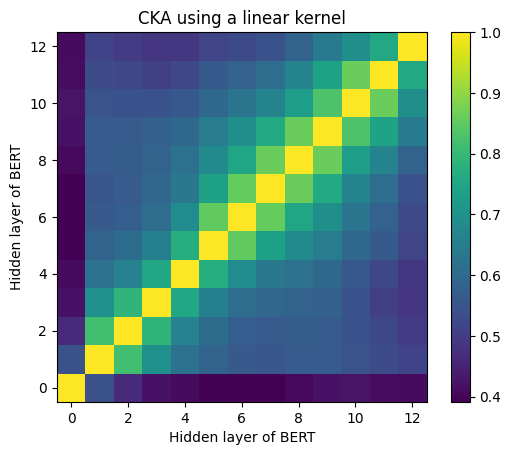

In [18]:
plot_heatmap_cka(bert_activations_np, bert_activations_np, "BERT", "BERT")

13it [00:27,  2.09s/it]


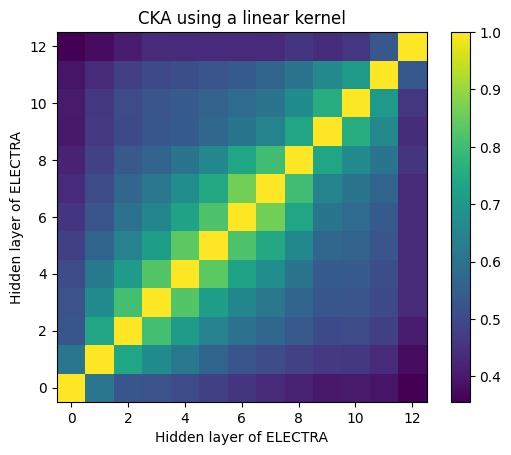

In [19]:
plot_heatmap_cka(electra_activations_np, electra_activations_np, "ELECTRA", "ELECTRA")

13it [00:25,  1.96s/it]


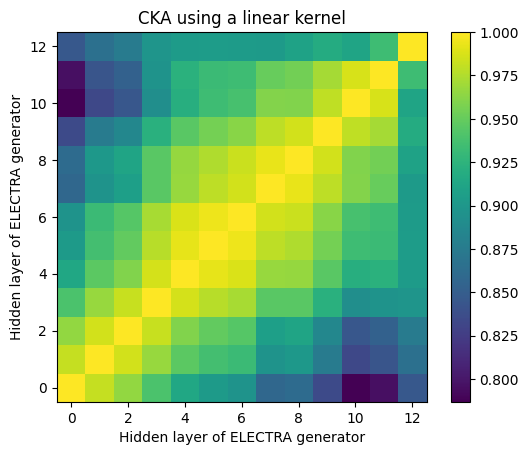

In [20]:
plot_heatmap_cka(electra_activations_gen_np, electra_activations_gen_np, "ELECTRA generator", "ELECTRA generator")

13it [00:26,  2.07s/it]


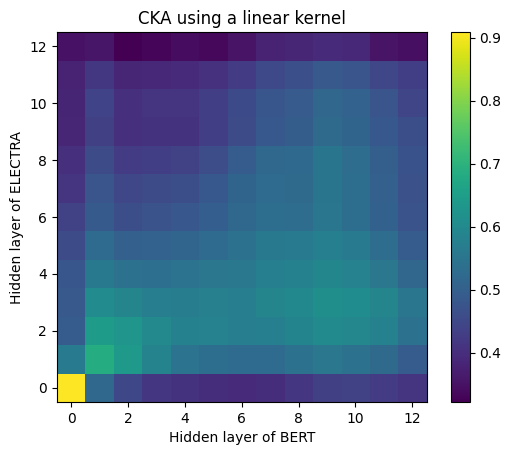

In [21]:
plot_heatmap_cka(electra_activations_np, bert_activations_np, "BERT", "ELECTRA")

13it [00:26,  2.01s/it]


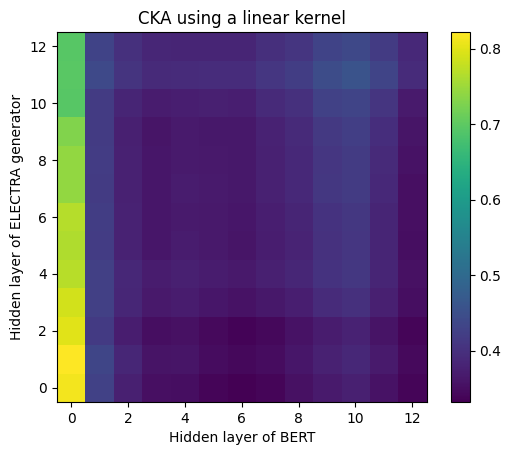

In [22]:
plot_heatmap_cka(electra_activations_gen_np, bert_activations_np, "BERT", "ELECTRA generator")